In [7]:
import os
import sys
import open3d as o3d
import numpy as np
import cv2
import copy
import matplotlib.pyplot as plt
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))
sys.path.append(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src/scripts/milestone_202110'))

from pkg.global_config import RNB_PLANNING_DIR
from pkg.utils.utils import *    
from pkg.utils.rotation_utils import *
from pkg.controller.combined_robot import *
from pkg.project_config import *
from utils.kiro_udp_send import start_mobile_udp_thread, send_pose_wait, get_xyzw_cur, get_reach_state
from utils.streaming import *
from utils.detection_util import *

CONNECT_CAM = False # True
ENABLE_DETECT = True
CONNECT_INDY = False # True
CONNECT_MOBILE = False # True 
SHOW_MOTION_RVIZ = False

ip_cur =  get_ip_address()
MOBILE_IP = "192.168.0.102"
INDY_IP = "192.168.0.3"
CAM_HOST = '192.168.0.10'

print("Current PC IP: {}".format(ip_cur))
print("Mobile ROB IP: {}".format(MOBILE_IP))
print("CAM SERVER IP: {}".format(CAM_HOST))

Current PC IP: 192.168.0.40
Mobile ROB IP: 192.168.0.102
CAM SERVER IP: 192.168.0.10


In [2]:
from pkg.controller.combined_robot import *
from pkg.project_config import *


# sock_mobile, server_thread = start_mobile_udp_thread(recv_ip=ip_cur)
crob = CombinedRobot(robots_on_scene=[
    RobotConfig(0, RobotType.indy7, None,
                INDY_IP, specs={"no_sdk":True})]
              , connection_list=[CONNECT_INDY])

connection command:
indy0: False


In [3]:
from pkg.geometry.builder.scene_builder import SceneBuilder
s_builder = SceneBuilder(None)
# s_builder.reset_reference_coord(ref_name="floor")

In [4]:
# xyz_rpy_robots = s_builder.detect_items(level_mask=[DetectionLevel.ROBOT])
xyz_rpy_robots = {"indy0": ((0,0,0), (0,0,np.pi))}
crob.update_robot_pos_dict(xyz_rpy_robots=xyz_rpy_robots)
gscene = s_builder.create_gscene(crob)

Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0]


In [5]:
gtems = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True)

Please create a subscriber to the marker


In [6]:
from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


## Add env

In [7]:
# geometry 추가
mobile_base = gscene.create_safe(gtype=GEOTYPE.BOX, name="mobile_base", link_name="base_link", 
                   dims=(0.6,0.4,0.439), center=(0,0,-0.439/2), rpy=(0,0,0), 
                   color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=False)
floor = gscene.create_safe(gtype=GEOTYPE.BOX, name="floor", link_name="base_link", 
                   dims=(10,10,0.01), center=(0,0,-0.439), rpy=(0,0,0), 
                   color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=False)

## Add cam

In [8]:
for gtem in gscene:
    round_it_str(gtem.dims)
    round_it_str(gtem.center)

In [9]:
from pkg.geometry.geotype import GEOTYPE
gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="cam", link_name="indy0_tcp", 
                   dims=(0.061,0.061,0.026), center=(-0.0785,0,0.013), rpy=(0,0,0), 
                   color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=False)

gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="cam_col", link_name="indy0_tcp", 
                   dims=(0.081,0.081,0.046), center=(-0.0785,0,0.013), rpy=(0,0,0), 
                   color=(0.0,1,0,0.3), display=True, fixed=True, collision=True)

viewpoint = gscene.create_safe(gtype=GEOTYPE.SPHERE, name="viewpoint", link_name="indy0_tcp", 
                   dims=(0.01,0.01,0.01), center=(-0.014,0,0), rpy=(0,0,-np.pi/2), 
                   color=(1,0,0,0.3), display=True, fixed=True, collision=False, parent="cam")

gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="body", link_name="indy0_tcp", 
                   dims=(0.067,0.067,0.0335), center=(-0.0785,0,-0.01675), rpy=(0,0,0), 
                   color=(0.8,0.8,0.8,1), display=True, fixed=True, collision=False)

gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="body_col", link_name="indy0_tcp", 
                   dims=(0.087,0.087,0.0535), center=(-0.0785,0,-0.01675), rpy=(0,0,0), 
                   color=(0.0,1,0,0.3), display=True, fixed=True, collision=True)

gscene.create_safe(gtype=GEOTYPE.SPHERE, name="backhead", link_name="indy0_tcp", 
                   dims=(0.067,0.067,0.067), center=(-0.0785,0,-0.0335), rpy=(0,0,0), 
                   color=(0.8,0.8,0.8,1), display=True, fixed=True, collision=False)

gscene.create_safe(gtype=GEOTYPE.SPHERE, name="backhead_col", link_name="indy0_tcp", 
                   dims=(0.087,0.087,0.087), center=(-0.0785,0,-0.0335), rpy=(0,0,0), 
                   color=(0.0,1,0,0.3), display=True, fixed=True, collision=True)

## move indy to viewing pose

In [ ]:
VIEW_POSE = np.deg2rad([  0., -28.,  85.,  -0.,  57., -180])
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_POSE))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        Qcur = np.deg2rad(indy.get_joint_pos())
else:
    Qcur = VIEW_POSE
gscene.show_pose(Qcur)

## Attach to detection server

In [8]:
if ENABLE_DETECT:
    attacth_to_server()

## 침대 인식

In [13]:
# Coordinate of stl model importing

# bed_model = o3d.io.read_triangle_mesh(MODEL_DIR + '/bed/bed.STL')
# # bed_model = o3d.io.read_triangle_mesh(MODEL_DIR + '/bed/bed_floor_centered_m_scale.stl')
# bed_model.vertices = o3d.utility.Vector3dVector(
#     np.asarray(bed_model.vertices) * np.array([1 / 1000.0, 1 / 1000.0, 1 / 1000.0]))
# FOR_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2, origin=[0, 0, 0])
# o3d.visualization.draw_geometries([bed_model, FOR_origin])

## Get image

In [10]:
CAM_HOST = '192.168.0.40'

In [11]:
if CONNECT_CAM:
    # rdict = send_recv_demo_cam({1:1}, host=CAM_HOST)
    rdict = stream_capture_image(ImageType.FirstView, 0, host=CAM_HOST)
    cam_intrins, d_scale = [rdict[key] for key in ["intrins", "depth_scale"]]
    set_cam_params(cam_intrins, d_scale)
else:
    cam_intrins = [1280, 720, 899.05322265625,  899.21044921875, 654.8836669921875, 352.9295654296875]
    d_scale = 0.0002500000118743628
    set_cam_params(cam_intrins, d_scale)

:: Load two point clouds and disturb initial pose.
:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.300.
:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.300.
:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.050,
   we use a liberal distance threshold 0.075.
[[ 0.80396147 -0.06237568 -0.62702311  0.5313216 ]
 [ 0.11889356 -0.98317962  0.25024969  0.44204891]
 [-0.61879967 -0.26994418 -0.76656368  4.67092195]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=5.336246e-01, inlier_rmse=3.183043e-02, and correspondence_set size of 32732
Access transformation to get result.
Transformation is:
[[ 0.78644385 -0.02962281 -0.65117687  0.57932519]
 [ 0.12991653 -0.99282066  0.20206828  0.49964464]
 [-0.63877267 -0.23839543

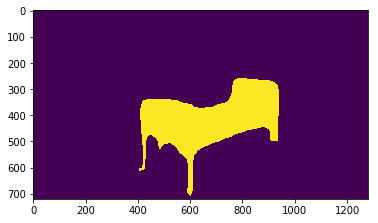

In [12]:
if CONNECT_CAM:
    bed_color_path = SAVE_DIR + '/bed.jpg'
    bed_depth_path = SAVE_DIR + '/bed.png'
else:
    bed_color_path = EXP_IMG_DIR + '/513.jpg'
    bed_depth_path = EXP_IMG_DIR + '/513.png'

# bed_color_path = "scripts/milestone_202110/save_img/526.jpg"
# bed_depth_path = "scripts/milestone_202110/save_img/526.png"

# Read color, depth image file, keep 16bit information
color_img_read = cv2.imread(bed_color_path, flags=cv2.IMREAD_UNCHANGED)
depth_img_read = cv2.imread(bed_depth_path, flags=cv2.IMREAD_UNCHANGED)


# Output of inference(mask for detected table)
mask_out = detect_from_server(color_img_read)

if mask_out is not None:
    plt.imshow(mask_out)
    
    # Crop masking part
    vis_mask = (mask_out * 255).astype('uint8')
    color_instance = cv2.bitwise_and(color_img_read, color_img_read, mask=vis_mask).astype(np.uint16)
    depth_instance = cv2.bitwise_and(depth_img_read, depth_img_read, mask=vis_mask).astype(np.uint16)
    cv2.imwrite(CROP_DIR + '/bed_crop.jpg', color_instance)
    cv2.imwrite(CROP_DIR + '/bed_crop.png', depth_instance)
    
#     set_cam_params(cam_intrins, d_scale)
    ICP_result_bed = process_bed_detection()

In [6]:
# 인식한 결과를 바탕으로 geometry 추가
T_co = ICP_result_bed
T_bc = viewpoint.get_tf(list2dict(VIEW_POSE, gscene.joint_names))
T_bo = np.matmul(T_bc, T_co)

# geometry 추가
# how to import gemoetry from stl file?

NameError: name 'viewpoint' is not defined

## 상두대 인식

In [15]:
# Coordinate of stl model importing

# top_table_model = o3d.io.read_triangle_mesh(MODEL_DIR + '/top_table/top_table.STL')
# top_table_model.vertices = o3d.utility.Vector3dVector(
#     np.asarray(top_table_model.vertices) * np.array([1 / 1000.0, 1 / 1000.0, 1 / 1000.0]))
# FOR_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2, origin=[0, 0, 0])
# o3d.visualization.draw_geometries([top_table_model, FOR_origin])

## Move and Scan

In [10]:
if CONNECT_CAM:
    color_path = SAVE_DIR + '/bed.jpg'
    depth_path = SAVE_DIR + '/bed.png'
else:
    color_path = EXP_IMG_DIR + '/513.jpg'
    depth_path = EXP_IMG_DIR + '/513.jpg'

# Robot이 어느쪽에서 찍었는 지 "LEFT" or "RIGHT"만 넣어주면 됨
TOP_TABLE_LOCATION = check_location_top_table(color_path, depth_path, ROBOT_LOCATION)

In [ ]:
# if CONNECT_CAM:
#     rdict = stream_capture_image(ImageType.FirstView, 1, host=CAM_HOST)
#     check_color_path = SAVE_DIR + '/top_table_check.jpg'
#     check_depth_path = SAVE_DIR + '/top_table_check.png'
# else:
#     check_color_path = EXP_IMG_DIR + '/top_table_check.jpg'
#     check_depth_path = EXP_IMG_DIR + '/top_table_check.png'

# # Check whether top table exist or not at scanning location
# check_top_table = check_top_table_exist(check_color_path, check_depth_path)

In [5]:
# 인식한 침대 결과를 기반으로 대략적인 위치로 모바일 로봇 이동하거나,적당한 위치로 이동한 후 
# 스캔 결과를 treat 해서 여기에 상두대가 있는 지 없는지 판단
# 인식한 침대 결과 기반으로 이동한 후, 위아래로 이미지 스캔하는 동작 + 스캔하면서 이미지 저장
# 이미지 저장 시작 - 모션 시작 - 모션 끝 - 이미지 저장 끝 (위아래 왕복 모션이 필요 loop closure detection 때문)
# for문 / while문으로 이미지 연속으로 저장 가능
for i in range(50):
    time.sleep(0.01)
    rdict = stream_capture_image(ImageType.CloseView, i, host=CAM_HOST)

In [6]:
if not CONNECT_CAM:
    COLOR_PATH = EXP_IMG_DIR + "/top_table/color"
    DEPTH_PATH = EXP_IMG_DIR + "/top_table/depth"
    INTRINSIC_PATH = EXP_IMG_DIR + "/top_table"

save_intrinsic_as_json(INTRINSIC_PATH + "/intrinsic.json")
INTRINSIC_PATH = INTRINSIC_PATH + "/intrinsic.json"

In [12]:
from boost_reconstruction.reconstruction_interface import reconstruction_interface_py as rci
rci.getReconstruction(COLOR_PATH, DEPTH_PATH, INTRINSIC_PATH, MILESTONE_DIR)

'========= Complete 3D Reconstruction ========='

In [15]:
pcd_top_table = o3d.io.read_point_cloud(MILESTONE_DIR + "/pcd_no.ply")
FOR_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2, origin=[0, 0, 0])
o3d.visualization.draw_geometries([pcd_top_table, FOR_origin])

In [ ]:
ICP_result_top_table = process_top_table_detection()

In [ ]:
# 인식한 결과를 바탕으로 geometry 추가
# 이때 pcd의 coordinate, 즉 카메라 시점은 첫번째 이미지를 찍었을 때의 시점임. 유의 필요
T_co = ICP_result_top_table
T_bc = viewpoint.get_tf(list2dict(VIEW_POSE, gscene.joint_names))
T_bo = np.matmul(T_bc, T_co)

# geometry 추가
# how to import gemoetry from stl file?